## Load and Prepare Data

In [3]:
from utils import *
import shap



In [4]:
# read data
file_name = "Estimation Data - Full Model - Monopoly - Whole Week.dta"
file_dir = "..\\data\\Full Model\\"
file_dir_name = file_dir + file_name
data = pd.read_stata(file_dir_name)
# keep advertiser ranks 1, 2
data = data[(data['advertiser_rank'] == 1) | (data['advertiser_rank'] == 2)]
(X, Y, T) = define_xyt(data)
# make T binary (only 0, 1)
T = T.apply(lambda x: 0 if x == 1 else 1)

## Estimate the Causal Forest Model

In [2]:
cf = CausalForestDML(
                        model_y=RandomForestRegressor(max_depth=10, min_samples_split=5000),
                        model_t=PropensityModel(max_depth=15, min_samples_split=3000),
                        discrete_treatment='True',
                        criterion='het',
                        n_jobs=n_jobs,
                        n_estimators=500,
                        min_samples_split=8000,
                        max_depth=15,
                        max_samples=0.01,
                        random_state=42,
                        verbose=0   
    )

tune the model:
start_time = time.perf_counter()

tune_params = cf.tune(
            Y=Y,
            T=T,
            X=X,
            params=cf_param_grid)

finish_time = time.perf_counter()

# print(f"finished tuning the model in {finish_time - start_time} seconds")

# fit the model using tuned parameters:
start_time = time.perf_counter()

cf.fit(Y=Y, T=T, X=X, inference="blb", cache_values=True)

finish_time = time.perf_counter()
print(f"finished fitting the model in {finish_time - start_time} seconds")


# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\CF - Rank 1, 2 - Full Data.pkl"
joblib.dump(cf, file_name)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


finished fitting the model in 28663.4096008 seconds


['..\\results\\Full Model\\Monopoly\\CF - Rank 1, 2 - Full Data.pkl']

#### Load Model

In [7]:

file_name = f"..\\results\\Full Model\\Monopoly\\CF - Rank 1, 2 - Full Data.pkl"
cf =  joblib.load(file_name)

#### Summary of the CATE Estimates

In [4]:
summary_table = cf.summary(decimals=6)
latex_summary = summary_table.as_latex()
with open('..\\results\\Full Model\\Monopoly\\cf 1,2 summary.tex', 'w') as f:
    f.write(latex_summary)
summary_table

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
                  Uncertainty of Mean Point Estimate                 
=====================================================================
mean_point stderr_mean   zstat    pvalue  ci_mean_lower ci_mean_upper
---------------------------------------------------------------------
 -0.000672    0.000342 -1.965388 0.049369     -0.001342        -2e-06
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
  0.00063       -0.002233        0.000461
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.001         -0.002          0.001
           Doubly Robust ATE on Training Data Results           
================================================================
    point_estimate  stderr   zstat    pvalue  ci_lower  ci_upper
----------------------------------------------------------------
ATE      -0.000652 2.5e-05 -26.115943    0.0 -0.000701 -0.000603
        Doubly Robust ATT(T=0) on Training Data Results         
================================================================
    point_estimate  stderr   zstat    pvalue  ci_lower  ci_upper
----------------------------------------------------------------
ATT      -0.000473 3.6e-05 -13.257409    0.0 -0.000543 -0.000403
       Doubly Robust ATT(T=1) on Training Data Results        
==============================================================
    point_estimate  stderr   zstat   pvalue ci_lower  ci_upper
--------------------------------------------------------------
ATT      -0.000853 3.5e-05 -24.58724    0.0 -0.00092 -0.000785
--------------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

# Shapley Values

In [93]:
X.rename(columns={
    'impression_repeat': 'Repeats',
     'impression_repeat_base_ad': 'Base Ad Repeats',
     'previous_clicks': 'Previous Clicks',
     'previous_clicks_base_ad': 'Base Ad Previous Clicks',
     'previous_clicks_all_ads': 'All Ads Previous Clicks',
     'total_visits': "Total Pages Visited",
     'visit_s1' : 'Art',
     'visit_s2' : 'Childcare',
     'visit_s3' : 'Education',
     'visit_s4' : 'Entertainment',
     'visit_s5' : 'Finance',
     'visit_s6' : 'Heath',
     'visit_s7' : 'Lifestyle',
     'visit_s8' : 'Movies',
     'visit_s9' : 'Music',
     'visit_s10' : 'Other',
     'visit_s11' : 'Politics',
     'visit_s12' : 'Sport',
     'visit_s13' : 'Technology',
     'sub_1' : 'Art FE',
     'sub_2' : 'Childcare FE',
     'sub_3' : 'Education FE',
     'sub_4' : 'Entertainment FE',
     'sub_5' : 'Finance FE',
     'sub_6' : 'Heath FE',
     'sub_7' : 'Lifestyle FE',
     'sub_8' : 'Movies FE',
     'sub_9' : 'Music FE',
     'sub_10' : 'Other FE',
     'sub_11' : 'Politics FE',
     'sub_12' : 'Sport FE',
     'sub_13' : "Technology FE",
     'publisher_rank_sub': 'Website Rank within Subject',
     'day': "Day",
     'hour': "Hour of the Day",
     'mobile': "Mobile",
    'ads_on_page': 'Ads on the Page'
       
}, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [100]:
shap_values = cf.shap_values(X[X.index % 1000 == 0])

100%|===================| 11550/11586 [04:55<00:00]        

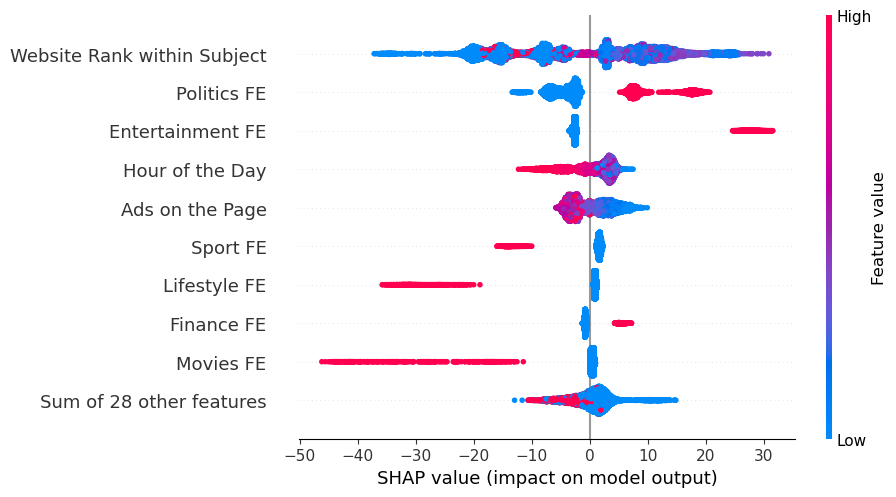

In [98]:
ad_2_mean_ctr = data.loc[(data['advertiser_rank'] == 1), 'is_clicked'].mean() 
shap.plots.beeswarm(shap_values['is_clicked']['advertiser_rank_1'] / ad_2_mean_ctr * 100, show=False)
# plt.savefig(f"..\\results\\Full Model\\Figures\\Shapley Values bw Ad 1, 2.jpg", dpi=600, bbox_inches='tight')
plt.savefig(f"..\\results\\Full Model\\Figures\\Shapley Values bw Ad 1, 2.eps", bbox_inches='tight')

# Treatment Effect Percentiles

#### Fit and Save M and E Functions

In [3]:
m = cf.model_y.fit(X[X.index % 20 == 0], Y[X.index % 20 == 0])
# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\M - Rank 1, 2 - Full Data.pkl"
joblib.dump(m, file_name)
e =  cf.model_t.fit(X[X.index % 20 == 0], T[X.index % 20 == 0])
# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\E - Rank 1, 2 - Full Data.pkl"
joblib.dump(e, file_name)

['..\\results\\Full Model\\Monopoly\\E - Rank 1, 2 - Full Data.pkl']

In [5]:
# Load the models above
file_name = f"..\\results\\Full Model\\Monopoly\\M - Rank 1, 2 - Full Data.pkl"
m = joblib.load(file_name)
file_name = f"..\\results\\Full Model\\Monopoly\\E - Rank 1, 2 - Full Data.pkl"
e = joblib.load(file_name)

#### Calculate CATEs and Their Confidence Intervals

In [9]:
te_ci = cf.const_marginal_effect_interval(X[X.index % 200 == 0])
te_h = np.squeeze(te_ci[1])
te_l = np.squeeze(te_ci[0])
te = (te_h + te_l) / 2
d = {'te': te, 'te_h': te_h, 'te_l': te_l}
te_dataset=pd.DataFrame(data=d)
te_dataset = te_dataset.sort_values('te')
te_dataset = te_dataset.reset_index(drop=True)
te_dataset['pct'] = te_dataset.index / len(te_dataset) * 100

In [81]:
percentiles = np.array([1.463, 20.01, 40.01, 60.02, 80.01, 99])
indices = np.floor(percentiles / 100 * len(te_dataset))
te_sub = te_dataset.loc[indices, ['pct', 'te', 'te_h', 'te_l']]
print(indices)

[  845. 11560. 23115. 34675. 46224. 57196.]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


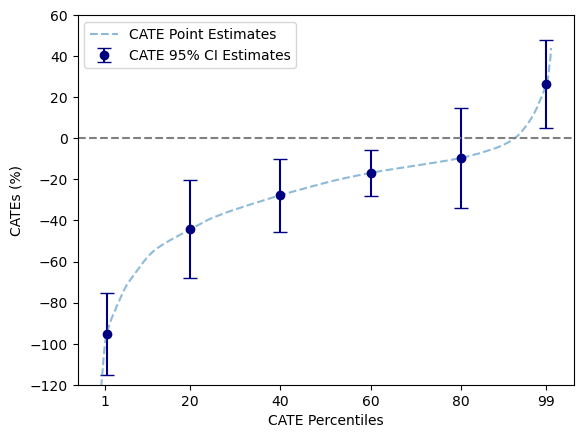

In [92]:
ad1_ctr = data.loc[data['advertiser_rank']== 1, 'is_clicked'].mean()
plt.errorbar(te_sub.pct, te_sub.te / ad1_ctr * 100, yerr=(te_sub.te_h-te_sub.te_l) / 2/ ad1_ctr * 100, fmt="o", capsize=5, color='navy')
plt.plot(te_dataset.pct, te_dataset.te / ad1_ctr * 100, alpha=0.5, linestyle='dashed')
plt.xlabel('CATE Percentiles')
plt.ylabel('CATEs (%)')
# plt.title("Treatment Effect Heterogeneity")
plt.legend(['CATE Point Estimates', 'CATE 95% CI Estimates'], )
plt.axhline(y=0, color='gray', linestyle='--')
plt.xticks([1, 20, 40, 60, 80, 99])
plt.ylim(-120, 60)

plt.savefig(f"..\\results\\Full Model\\Figures\\Treatment Effect bw Ad 1, 2.jpg", dpi=600, bbox_inches='tight')
plt.savefig(f"..\\results\\Full Model\\Figures\\Treatment Effect bw Ad 1, 2.eps", bbox_inches='tight')
plt.show()


## Estimated Click Rates

In [89]:
(X, Y, T) = define_xyt(data)
te_dataset['e_hat'] = e.predict_proba(X[X.index % 10 == 0])[:,1]
te_dataset['m_hat'] = m.predict(X[X.index % 10 == 0])

te_dataset['ctr_1'] = np.maximum(te_dataset['m_hat']- te_dataset['te'] * te_dataset['e_hat'], 0) 
te_dataset['ctr_2'] = np.maximum(te_dataset['ctr_1'] + te_dataset['te'], 0)

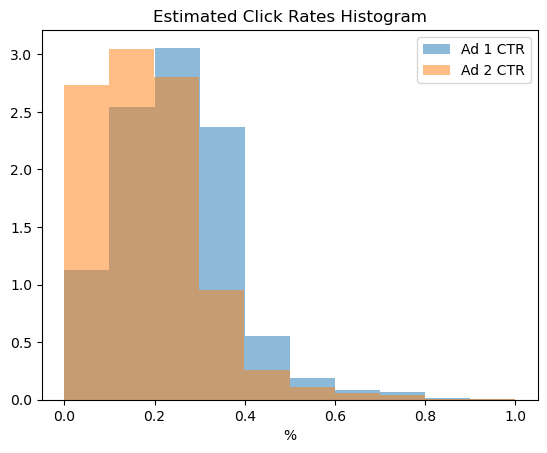

In [97]:
plt.hist(100 * te_dataset.loc[te_dataset['ctr_1']< 0.01, 'ctr_1'], alpha=0.5, density=True)
plt.hist(100 * te_dataset.loc[te_dataset['ctr_2']< 0.01, 'ctr_2'], alpha=0.5, density=True)
plt.legend(['Ad 1 CTR', 'Ad 2 CTR'])
plt.xlabel('%')
plt.title('Estimated Click Rates Histogram')
plt.show()

# Feature Importances

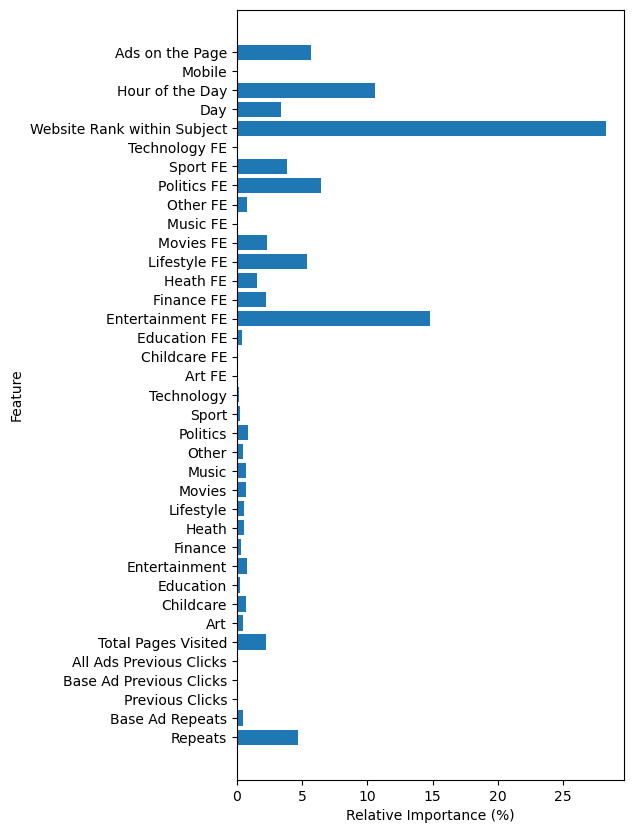

In [120]:
imp = cf.feature_importances_
imp = imp / np.sum(imp) * 100
plt.rcParams["figure.figsize"] = (5,10)
plt.barh(X.columns, imp)
plt.xlabel('Relative Importance (%)')
plt.ylabel('Feature')
plt.savefig(f"..\\results\\Full Model\\Figures\\Ad 1,2 TE Feature Importances.eps", bbox_inches='tight')